# Homework #4 (Due 10/08/2020, 11:59pm)
## EM for Data Augmentation; MCMC Sampling

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:** Assaraf David

**Students collaborators:** Ancel Gael, Pellegrin Raphael

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import itertools
import scipy
%matplotlib inline

---

# Problem Description: Latent Variables for Data Augmentation

A botany research lab in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to study the genetic factor that creates an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each. 

Out of 197 initial cross-breedings, the nursery obtained the following counts of the four types of child plants:

$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$

where $y_i$ represents the number of child plants that are of type $i$.

The geneticist in the lab know that the probability of obtaining each type of child plant in any single breeding experiment is correlated by the inheritability $\theta$ of a specific genetic factor. That is, the probabilities of obtaining the four subtypes are as follows:

$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4},$$

where $\theta \in [0, 1]$ is unknown.

The lab chose to model the observed data using a multinomial model:

\begin{align}
Y & \sim Mult\left(197, \left[\frac{\theta+2}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{align}

The aim of this problem is to estimate $\theta$ from the observed counts.

## Part I: MLE Through Latent Variable Augmentation and EM
In models where directly computing the MLE is hard (you can think about if that is the case here), the optimization of the likelihood can often be simplified by introducing a latent variable into the model and then optimize the liklelihood using EM - this process is called ***data augmentation***.

The nursery augmented the data with a new variable $Z$ such that:
$$Z + (y_1 - Z) = y_1.$$
That is, using $Z$, they are breaking $y_1$, the number of Type I child plants, into two subtypes, with $Z$ being the count of Subtype #1 and $(y_1-Z)$ being the count of Subtype #2. The lab posited the probability of obtain the two subtype $\theta/4$ and $1/2$, respectively.

The augmented model (which includes the observed data $y$ and the latent variable $z$ they introduced) they derived is as follows:

\begin{aligned}
Z | Y, \theta &\sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)\\
Y & \sim Mult\left(197, \left[\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{aligned}

1. Show that the assumptions the lab made about $Z$ implies that $Z | Y, \theta \sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)$.<br><br>

2. Derive the EM updates for the augmented latent variable model.<br><br>

3. Implement the EM algorithm to estimate the MLE of $\theta$. Choose an appropriate initialization point and an appropriate stopping condition.<br><br>

4. Explain the potential advantage of augmenting likelihood models with a latent variable (e.g. what aspects of the MLE computation becomes easier or more efficient?).

#### 1. Law of $Z|Y, \theta$
$Z|Y, \theta$ = Number of flowers of Subtype #1 in type 1 knowing the number of flowers in Type 1 (dependency on $Y$) and knowing the probability of being part of Type 1 (dependency on $\theta$).

Therefore, we will re-write:
$Z|Y, \theta = \sum_{i=1}^{y_1}\mathbb{1}_{\textit{the flower i is subtype 1|the flower i is type 1}}$.

Therefore, with $X_i= \mathbb{1}_{\textit{the flower i is subtype 1|the flower i is type 1}}$, if we succeed in showing that every $X_i\sim\mathbb{B}(\frac{\theta}{\theta+2})$, then we would have succeeded in showing that $Z | Y, \theta \sim Bin(y_1, \frac{\theta}{2 + \theta})$. 

Indeed, since the lab assumed that $Y \sim Mult(197, [\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}])$, it implicitely assumed that all the observations were independent. Resulting in the fact that the $X_i = g(Y_i)$ are also independent.

This is accomplished by saying that X is a binary variable, and that $\mathbb{P}(X = 1) = \mathbb{P}(\textit{the flower subtype is 1|the flower type is 1})  = \frac{\frac{\theta}{4}}{\frac{\theta+2}{4}} = \frac{\theta}{\theta+2}$. 

#### 2. EM Updates 
##### E step 
$$
q_{new}(Z_n) = arg\,max_qELBO(\theta_{old}, q) = p(Z_n|Y_n, \theta_{old})  \sim Bin(y_1, \frac{\theta_{old}}{2 + \theta_{old}})
$$
##### M step 
$$
\theta_{new} = arg\,max_{\theta}ELBO(\theta, q_{new})
$$

$$
ELBO(\theta, q_{new}) = {\mathbb{E}_{Z \sim q_{new}(Z|Y, \theta_{old})}[log(p(Y, Z| \theta))]}
$$

Using Bayes' theorem, we get that $p(Y, Z| \theta) = p(Y|\theta)p(Z|Y, \theta)$ = MultiNomial * Binomial.

We have that 
$$p(z_i|y_i, \theta) = {y_1 \choose z_i}*(\frac{\theta}{\theta+2})^{z_i}(\frac{2}{\theta+2})^{y_1-z_i} = {y_1 \choose z_i}(\frac{\theta}{2})^{z_i}*(\frac{2}{\theta+2})^{y_1}$$.

We also have that 
$$
p(y_i|\theta) = Cst*(\frac{\theta+2}{4})^{y_1}*(\frac{1 - \theta}{4})^{y_2}*(\frac{1 - \theta}{4})^{y_3}*(\frac{\theta}{4})^{y_4}
$$
Therefore,
$$
p(y_i|\theta)p(z_i|y_i, \theta) = Cst*{y_1 \choose z_i}(\frac{\theta}{2})^{z_i}*(\frac{1}{2})^{y_1}*(\frac{1 - \theta}{4})^{y_2}*(\frac{1 - \theta}{4})^{y_3}*(\frac{\theta}{4})^{y_4} = Cst*{y_1 \choose z_i}(\frac{\theta}{2})^{z_i}*(\frac{1 - \theta}{4})^{y_2}*(\frac{1 - \theta}{4})^{y_3}*(\frac{\theta}{4})^{y_4}
$$

Now, let's take the log of this quantity: 
$$
log[p(y_i, z_i|\theta)] = Cst+ log({y_1 \choose z_i})+z_ilog(\frac{\theta}{2}) + y_2log(\frac{1 - \theta}{4}) + y_3log(\frac{1 - \theta}{4})+ y_4log(\frac{\theta}{4})
$$
$$
\mathbb{E}_{Z \sim q_{new}(Z|Y, \theta_{old})}[log(p(y_i, z_i| \theta))] = Cst+ Cst(\theta_{old})+y_1*\frac{\theta_{old}}{\theta_{old}+2}log(\frac{\theta}{2}) + y_2log(\frac{1 - \theta}{4}) + y_3log(\frac{1 - \theta}{4})+ y_4log(\frac{\theta}{4})
$$

Now, we know that 
$$
\theta_{new} = arg\,max_{\theta \in [0; 1]}\quad{y_1\frac{\theta_{old}}{\theta_{old}+2}log(\theta) + y_2log(1 - \theta) + y_3log(1 - \theta)+ y_4log(\theta)} = arg\,max_{\theta \in [0; 1]}\phi(\theta)
$$
Let us find the stationnary points of $\phi$.
$$
\nabla(\phi) = y_1\frac{\theta_{old}}{\theta_{old}+2}\frac{1}{\theta} - \frac{y_2}{1 - \theta} - \frac{y_3}{1 - \theta} + \frac{y_4}{\theta}.
$$
$$
\nabla(\phi) = 0 \iff \theta = \frac{y_1\frac{\theta_{old}}{\theta_{old}+2}+y_4}{y_1\frac{\theta_{old}}{\theta_{old}+2}+y_2+y_3+y_4}
$$

Therefore, $\phi$ has only one stationary point $\theta$ and it verifies the constraints. By checking that $\nabla^2(\phi) < 0$, we can conclude that we have found the unique maximiser, which appears to be in $[0; 1]$: we have found the global optimum to the constrained optimization problem. 

Therefore, the updates can be obtained by: 

$$\theta_{new} = \frac{y_1\frac{\theta_{old}}{\theta_{old}+2}+y_4}{y_1\frac{\theta_{old}}{\theta_{old}+2}+y_2+y_3+y_4}$$

#### 3. Approximating the MLE estimator of $\theta$

Let us recall that the whole point of the EM algorithm is to approximate the Maximum Likelihood Estimation of the parameters of our distribution for our target variable but also of our latent variable. The ELBO is a lower bound on the objective function to maximize and optimizing the ELBO does not guarantee to get a reliable estimation of $\theta^{MLE}$.
There are two choices to be made in order to implement the EM algorithm: choose an initial parameter $\theta$ and determine the stopping rule. 

Here, the initial parameter $\theta$ will have very little importance. For the stopping rule, we will stop when the ELBO does not improve anymore. 

I will also take the opportunity to visualize how well our model likelihood improves as the ELBO improves. 

In [2]:
from scipy.special import comb, gamma
y1, y2, y3, y4, n = 125, 18, 20, 34, 197

In [3]:
def iterations(theta):
    return (y1*theta/(theta+2)+y4)/(y1*theta/(theta+2)+y2+y3+y4)

##### Preliminary step: Visualization of the updates of $\theta$

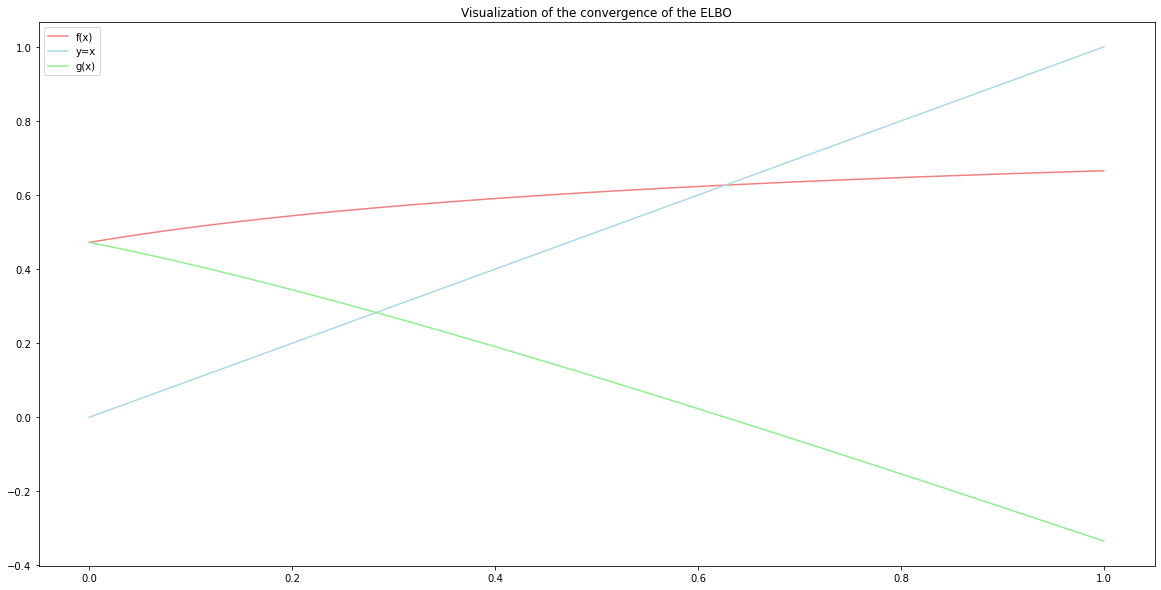

In [4]:
plt.figure(figsize=(20, 10))
plt.title('Visualization of the convergence of the ELBO')
plt.plot(np.linspace(0, 1, 1000), [iterations(n) for n in np.linspace(0, 1, 1000)], color='lightcoral', label='f(x)')
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), color='lightblue', label='y=x')
plt.plot(np.linspace(0, 1, 1000), np.asarray([iterations(n) for n in np.linspace(0, 1, 1000)])- np.linspace(0, 1, 1000), color='lightgreen',label = 'g(x)')
plt.legend()
plt.show()

Therefore, from what we can see above, the function $g(x) = f(x)-x$ is ascending on [0; $\theta_{lim}$] and non ascending  on [$\theta_{lim}$; 1], meaning that the $(\theta_n)_n$ numbers will converge no matter what our starting point is. We will also have a fast convergence towards our limit, which is the point where $f$ and $y$ intersect. 

Note:this is very specific to this case, where the E-step does not add up any information. 

##### First step: Computing the ELBO
From our previous calculus, we know that we can express the ELBO as:
$$
{\mathbb{E}_{Z \sim q_{new}(Z|Y, \theta_{old})}[log(p(y, z| \theta))]} =  \mathbb{E}_{Z \sim q_{new}(Z|Y, \theta_{old})}[Cst+ log({y_1 \choose z_i})+z_ilog(\frac{\theta}{2}) + y_2log(\frac{1 - \theta}{4}) + y_3log(\frac{1 - \theta}{4})+ y_4log(\frac{\theta}{4})]
$$
The first Constant is the Multinomial constant, that won't change over the iterations, so there is no point in computing it. However, we do need to compute the second one. 

We will compute it this way, using the fact that $z_i$ follows a Binomial law: 
$$
\mathbb{E}_{Z \sim q_{new}(Z|Y, \theta_{old})}[log({y_1 \choose z_i})] = \sum_{i=1}^{y_1}log{y_1 \choose k}\mathbb{P}(z_i=k)
$$

In [5]:
def expectancy(theta): #helper function to compute the ELBO
    binomial_coefficients = np.array([comb(y1, k) for k in range(0, y1+1)])
    theta_powered = np.array([(theta/2)**k for k in range(0, y1+1)])
    log_binomial = np.log(binomial_coefficients)
    probabilities = theta_powered*binomial_coefficients
    inner_argument = log_binomial*probabilities
    constant = (2/(2+theta))**y1
    return constant*np.sum(inner_argument)

In [6]:
def ELBO(theta, theta_old, E=True): #it depends on the law of q via the expectancy and the iterations of theta
    if E:
        theta_old = theta
    # if we are in the M phase, theta = iterations(theta_old)
    return expectancy(theta_old) + y1*(theta_old/(theta_old+2))*np.log(theta/2) + y2*np.log((1-theta)/4) + y3*np.log((1-theta)/4) + y4*np.log(theta/4)
    

##### Second step: Visualizing the Improvements of the ELBO

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def EM(theta_0):
    theta = theta_0
    precision = 1
    ELBO_old = 1
    ELBO_values = []
    theta_values = [theta_0]
    while precision > 1e-5:
        theta_old = theta
        ELBO_E = ELBO(theta, theta_old)
        theta = iterations(theta_old)
        theta_values.append(theta)
        ELBO_M = ELBO(theta, theta_old)
        ELBO_values.append(ELBO_M)
        precision = np.abs(ELBO_old - ELBO_M)
        ELBO_old = ELBO_M
    return ELBO_values, theta_values

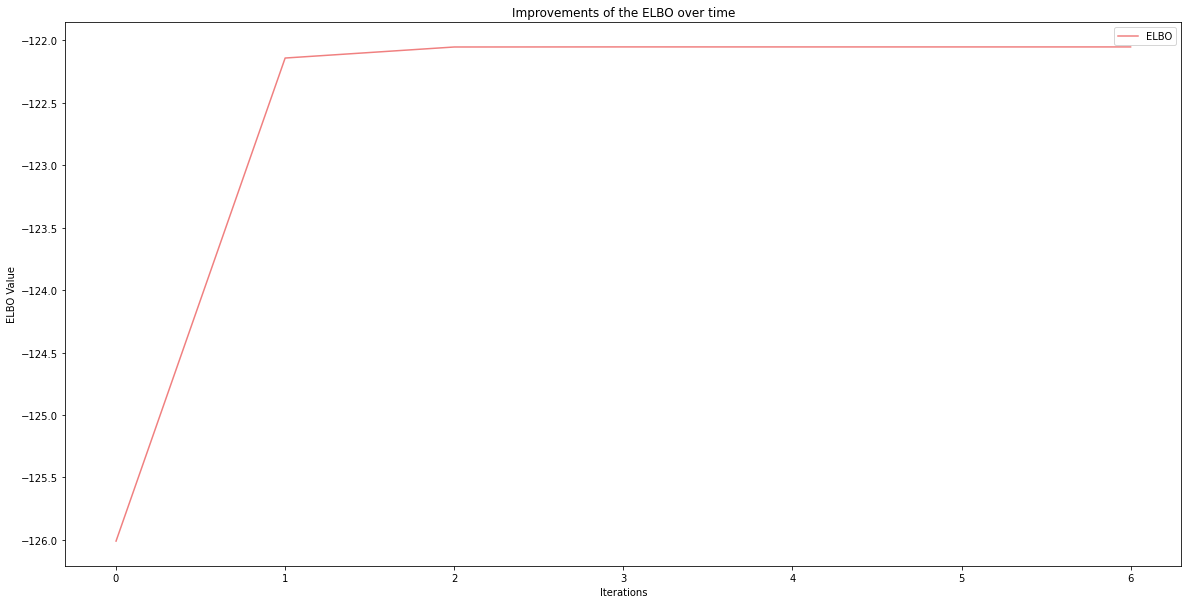

In [9]:
ELBO_values, theta_values = EM(0)
plt.figure(figsize = (20, 10))
plt.xlabel('Iterations')
plt.ylabel('ELBO Value')
plt.title('Improvements of the ELBO over time')
plt.plot(ELBO_values, label='ELBO', color='lightcoral')
plt.legend()
plt.show()

##### Third step: Visualizing the improvements of the Log-Likelihood as the ELBO increases

The likelihood of the model is the likelihood of a Multinomial model. Therefore, up to a constant, the log-likelihood of the model is  
$$
\mathcal{L}(Y|\theta) = y_1log(\frac{\theta+2}{4}) + y_2log(\frac{1 - \theta}{4}) + y_3log(\frac{1 - \theta}{4})+ y_4log(\frac{\theta}{4})
$$

In [10]:
def likelihood(theta):
    return y1*np.log((theta+2)/4) + y2*np.log((1-theta)/4) + y3*np.log((1-theta)/4) + y4*np.log(theta/4)

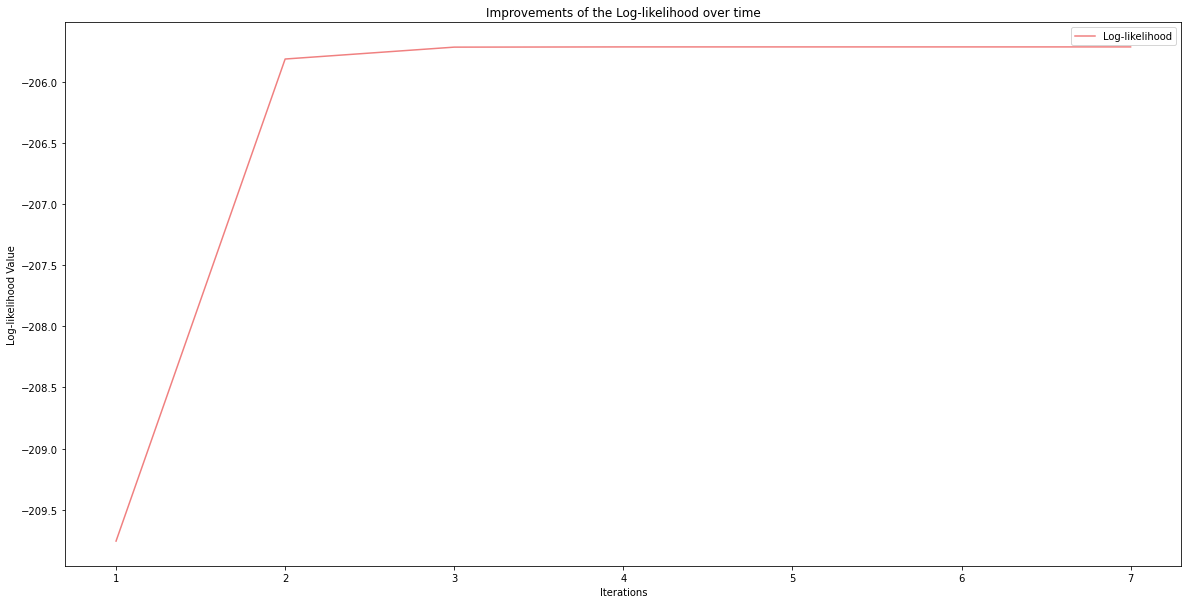

In [11]:
likelihood_values = [likelihood(theta) for theta in theta_values]
plt.figure(figsize = (20, 10))
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood Value')
plt.title('Improvements of the Log-likelihood over time')
plt.plot(likelihood_values, label='Log-likelihood', color='lightcoral')
plt.legend()
plt.show()

We can clearly see that, as the ELBO improves over time, we also have an increase in the Log-Likelihood. Note that the ELBO is not larger than the Log-Likelihood, we have just not computed the Log-likelihood constant (the normalizing constant of the MultiNomial distribution). 

#### 4. Potential advantage of augmenting likelihood models with a latent variable

By augmenting a likelihood model with a latent variable, the computation to solve for the maximimum likelihood estimate of the parameters becomes more efficient. This is because when we combine the expectation and maximization steps, we can (iteratively) solve for the maximum likelihood estimate of the parameters as the solution to a quadratic. Because successive iterations of the E and M steps increase the likelihood, convergence of the successive estimates implies a stationary point of the likelihood. The EM algorithm's iterative convergence to solve for a consistent maximum likelihood estimate using a latent variable could also be desirable in cases where due to incomplete data, there are multiple possible local maxima for the likelihood.

---

# Problem Description: Modeling Kidney Cancer Data
In this problem, we will work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on the mechanics of seting up a statistical model for this data set and performing inference on it. In the next homework, we will focus on interpreting this model and comparing it with others in context.**

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}

where $\alpha, \beta$ are hyper-parameters of the model.


Rather than arbitrarily choosing the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

In this problem, you will implement a modified Gibbs sampler to sample from the posterior of this complex model.

## Part I: The Conditional Distributions
1. Justify our choice to use a hierarchical model. Specifically, explain the draw-backs of using MLE estimates of $\theta_j$ to represent the underlying cancer rates of these counties (recall the discussion in Lecture #3). Explain the draw-backs of choosing specific values for the hyper-parameters of $\alpha$ and $\beta$ rather than putting priors on them (recall the discussion in Homework #1 about priors).<br><br>

2. Verify that the conditional distributions are 
\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &= Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta),\\
p(\alpha, \beta | \theta, y) &\propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
\end{align}
  where we use the following notation:
\begin{align}
\theta &:= \{ \theta_j\}_{j=1, \ldots, N}\\
\theta_{-j} &:= \{ \theta_i\}_{i=1, \ldots, j-1, j+1,\ldots, N}\\
y &:= \{y_j \}_{j=1, \ldots, N}\\
y_{-j} &:= \{ y_i\}_{i=1,\ldots, j-1, j+1,\ldots, N}\\
\end{align}
  Unfortunately, you see that $p(\alpha, \beta | \theta, y)$ doesn't resemble the pdf of a nice simple distribution; that is, it is unclear how to sample from it.

In [12]:
df_kidney = pd.read_csv('kcancer.csv')

#### 1. Choice of a Hierarchical Model

The choice of not leveraging MLE for $\theta_j$ is that the MLE is prone to overfitting. In counties with very few examples of positive kidney cancer, we might end up with a model being completely off when it comes to predictions. 
The choice of a hierarchical model is motivated by the fact that we have uncertainty over our first hyperparameters $\alpha$ and $\beta$. Since we do not know if our amount of data will be sufficient in order to 'cover' the effect of our prior, instead of arbitrary choosing our hyperparameters (and maybe resulting in a model very dependent on this hyperparameters $\alpha$ and $\beta$), we chose to insert priors on this distribution. The resulting model is a hierarchical model, and we know from the lecture that this resulting hierarchical model will be less dependent on the final hyperparameters we set on $\alpha$ and $\beta$, ie $a$ and $b$ and $c$ and $d$.

#### 2. Conditional Distributions
##### For the first distribution, we have 
$$
p(\theta_j | \theta_{-j}, y, \alpha, \beta) = \frac{p(y, \theta, \alpha, \beta)}{p(\theta_{-j}, y, \alpha, \beta)} \quad and \quad p(y, \theta, \alpha, \beta) = p(y|\theta, \alpha, \beta)p(\theta|\alpha, \beta)p(\alpha, \beta). 
$$
By independency, we can handle all of these terms, the first one is a product of Poisson pdf, second one is a product of Gamma pdf.
Now, we will handle the denominator. 
$$
p(\theta_{-j}, y, \alpha, \beta) = p(\theta_{-j}, y | \alpha, \beta)p(\alpha, \beta) = p(y|\theta_{-j}, \alpha, \beta)p(\theta_{-j}|\alpha, \beta)p(\alpha, \beta)
$$

Therefore, the quotient is equal to:
$$
\frac{p(y_j|\theta_j, \alpha, \beta)p(\theta_j|\alpha, \beta)}{p(y_j|\theta_{-j}, \alpha, \beta)}
$$

We will only take care of the term which is at the numerator, the denominator will be the normalizing constant (= $\int_{\theta_j}{p(y_j|\theta_j, \alpha, \beta)p(\theta_j|\alpha, \beta)d\theta_j} $).
$$
p(y_j|\theta_j, \alpha, \beta)p(\theta_j|\alpha, \beta) = Poisson(5n_j\theta_j)Ga(\theta_j; \alpha, \beta) = e^{-5n_j\theta_j}\frac{(5n_j\theta_j)^{y_j}}{y_j!}*\frac{\beta^{\alpha}\theta_j^{\alpha-1}e^{-\beta\theta_j}}{\Gamma(\alpha)} \propto (5n_j+\beta)^{\alpha+y_j}\theta_j^{\alpha+y_j-1}e^{-(\beta+5n_j)\theta_j}.
$$

Therefore, $p(\theta_j | \theta_{-j}, y, \alpha, \beta) = Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta).$

##### For the second distribution, we have that 
$$
p(\alpha, \beta | \theta, y) = \frac{p(\theta, y |\alpha, \beta)p(\alpha, \beta)}{p(\theta, y)}
$$
    We write $p(\theta, y) = p(y | \theta)p(\theta) = p(y|\theta)\int_{\alpha, \beta}{p(\theta|\alpha, \beta)d\alpha d\beta}$ independent of $\alpha$ and $\beta$.
We also write $p(\theta, y |\alpha, \beta) = p(y | \theta, \alpha, \beta) p(\theta|\alpha, \beta)$. 

Therefore, the only terms in $p(\alpha, \beta | \theta, y)$ depending on $\alpha$ and $\beta$ are $p(\theta|\alpha, \beta)*p(\alpha, \beta)$.

For every $j$ in $1, ..., N$, we have $p(\theta_j|\alpha, \beta) = \beta^{\alpha}\frac{\theta_j^{\alpha-1}e^{-\beta\theta_j}}{\Gamma(\alpha)}$. By independence, we have $p(\theta | \alpha, \beta) = \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)}[\prod_{j=1}^N{\theta_j^{\alpha-1}}]e^{-\sum_j\beta\theta_j}$
Finally, with $p(\alpha, \beta) = p(\alpha)p(\beta)$ and keeping only the terms depending on $\alpha$ and $\beta$, we can conclude that $
p(\alpha, \beta | \theta, y) \propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} [\prod_j \theta_j^{\alpha - 1}] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}$.


## Part II: Metropolis-Hastings-in-Gibbs
1. When one or more conditional distributions in a Gibbs sampler do not have closed forms (this is the case for most models), we often sample from these conditionals using another MCMC method (e.g. Metropolis Hastings). That is, we modify the Gibbs sampler as follows:

  **I.** Sample $\theta_j$ using the closed form for $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$.
  
  **II.** Sample $\alpha, \beta$ from $p(\alpha, \beta | \theta, y)$ using a Metropolis-Hastings step (i.e. use a proposal distribution to propose a sample and the MH reject/accept mechanism to accept the new sample or keep the old).
  
  This algorithm is called a ***Metropolis-Hastings-in-Gibbs sampler***. <br><br>
  
  Note that we computed $p(\alpha, \beta | \theta, y)$ only up to a constant. Show why we don't need to know the normalizing constant of $p(\alpha, \beta | \theta, y)$ when we perform MH sampling.<br><br>
  
3.  Implement and run a Metropolis-Hastings-in-Gibbs sampler for the kidney cancer model.

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = 1.54517349188, \beta_0 = 133514.171939$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10<br><br>
  
4. Check for and discuss the convergence of your sampler. If you think your sampler has converged, explain why. If you believe your sampler has not converged, explain what next steps you might take to determine which design choices were problemmatic.
  
  **Important Disclaimer:** Convergence in a untweaked sampler may be unlikely after only 100,000 Gibbs sweeps. We are not asking you in this homework to achieve convergence, but you must demonstrate that you know how to perform diagnostics on your sampler.<br><br>
  
  
**Optional not Required:** Tweak the settings in your sampler (e.g. number of sweeps) in order to achieve reasonable confidence that your sampler has converged. Reconsider also other design choices like, do you need to sample $\alpha$ and $\beta$ jointly?<br><br>

**Extra Credit:** Prove the correctness of Metropolis-Hastings-in-Gibbs sampler. You need to state the definition of the correctness of an MCMC sampler and prove that Metropolis-Hastings-in-Gibbs sampler satisfy these properties.

#### 1. Normalizing constant of $p(\alpha, \beta |\theta, y)$
We use the distribution $p(\alpha, \beta |\theta, y)$ in the second step of the Metropoli-Hasting-in-Gibbs sampler: we sample $\alpha, \beta$ from $p(\alpha, \beta | \theta, y)$ using a MH step. Formally, this means that $p(\alpha, \beta |\theta, y)$ is our target distribution and, thanks to a proposal distribution $q$, we will accept samples from $q$ based on the ration 
$$
\frac{\frac{p(\alpha_{new}, \beta_{new}|\theta, y)}{q(\alpha_{new}, \beta_{new}|\alpha_{old}, \beta_{old})}}{\frac{p(\alpha_{old}, \beta_{old}|\theta, y)}{q(\alpha_{old}, \beta_{old}|\alpha_{new}, \beta_{new})}}
$$
Therefore, we leverage a ratio for the distribution $p(\alpha, \beta |\theta, y)$, killing the normalization constraint.

#### 2. Metropolis-Hastings-in-Gibbs sampler

Let us first recall the objective of the Metropolis-Hastings-like samplers.

##### Objective: Sample from an unknown disribution

$\textbf{Tool used : Markov Chains :}$ Instead of directly sampling from a complicated posterior, we are going to create a Markov Chain that will utimately have the target distribution. We say the the chain will have miwed. This is called a MCMC sampler. A way to do so is via Metropolis-Hastings algorithm. This algorithm ensures that we create an irreducible Markov Chain (thus ensuring that there is a unique stationnary distribution) which has stationnary distribution our target distribution. This guarantees that this Markov Chain converges towards our target distribution.   

The outline of this algorithm is as follows: we use a proposal distribution, and based on an acceptance rate, we accept or reject the samples produced by the proposal distribution. We outline here a step of the MH algorithm, ie creating a sample from 
a chain that will converge towards our target distribution.

Pick: a proposal distribution $q$, a initial value $\theta_0$.

- $\textbf{Proposal : }$pick a sample $\theta_{prop} \sim q(\theta|\theta_{old})$
- $\textbf{Acceptance : }$
    - generate $U \sim \mathcal{U}(0, 1)$
    - compute $\alpha(\theta_{prop}, \theta_{old})$ = $min(1, \frac{\frac{p(\theta_{prop})}{q(\theta_{prop}|\theta_{old})}}{\frac{p(\theta_{old})}{q(\theta_{old}|\theta_{prop})}})$
    - if $U \leq \alpha(\theta_{prop}, \theta_{old})$:
        - add $\theta_{prop}$ to list of accepted samples
        - $\theta_{old} = \theta_{prop}$
    - else : add $\theta_{old}$ to list of accepted samples

First, I need to get the values of $y$ and $n$ from the data, in order to define the target proposition.

In [13]:
n, y, N = df_kidney['pop'].values, df_kidney['dc'].values, len(df_kidney)

Then, we have selected a bivariate Normal distribution for the proposal distribution, we will define functions in order to propose samples and compute their likelihood. Later on, for the sake of computation, we will compute the log of these likelihoods in order to get tractable quantities. 

In [14]:
def multivariate_normal_sample(Covariance_matrix, alpha, beta):  #proposal step of the MH algorithm
    return np.random.multivariate_normal([alpha, beta], Covariance_matrix)

In [15]:
def multivariate_normal_pdf(x, Covariance_matrix, alpha, beta):  #acceptance step of the MH algorithm
    return scipy.stats.multivariate_normal.pdf(x, cov = Covariance_matrix, mean = [alpha, beta])

The only thing we need from the target distribution is to compute the likelihood of a new sample $(\alpha, \beta)$. Actually, we will compute the log-likelihood of a new sample. Let us recall that the close-form of the likelihood of the target distribution is proportional to : 

$$
\frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} [\prod_j \theta_j^{\alpha - 1}] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
$$

In [16]:
def log_alpha_beta_distribution_target(alpha, beta, theta):
    log_constant = N*(alpha*np.log(beta) - np.log(gamma(alpha)))  # pre-multiplicative term 
    log_product = (alpha-1)*np.sum(np.log(theta))  # the log of the product 
    argument = -beta*np.sum(theta) - d*beta - b*alpha
    return log_constant+log_product+argument+(a-1)*np.log(alpha)+(b-1)*np.log(beta)    

Our external generating process is a Gibbs step. The Gibbs sampler is a case-specific Metropolis-Hastings algorithm. The only difference is that, at every step, we update only one coordinate of our vector, and the acceptance rate of this sample is 1. We sample directly from the posterior, which has a convenient closed-form. Let us recall that: 
$$
p(\theta_j | \theta_{-j}, y, \alpha, \beta) = Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta).
$$


In [17]:
def Gibbs_step(alpha, beta, theta): #returns a parameter vector theta with an updated j-th coordinate
    j = int(np.random.uniform(0, N))
    theta[j] = np.random.gamma(alpha+y[j], 1./(5*n[j]+beta))
    return theta

We are now ready to implement the final sampler, which is a MH-in-Gibbs sampler. It is pretty straightforward from the previous considerations. After every update of our vector $\theta$, we sample a vector $(\alpha, \beta)$ and check for acceptance or rejectance for this new sample. 

In [18]:
def MH_step(alpha_old, beta_old, theta):
    alpha_new, beta_new = multivariate_normal_sample(Covariance_matrix, alpha_old, beta_old)
    U = np.random.uniform(0, 1)
    likelihood_prop_old = multivariate_normal_pdf(x = [alpha_old, beta_old], Covariance_matrix = Covariance_matrix, alpha=alpha_new, beta=beta_new) #denominator of the denominator
    likelihood_prop_new = multivariate_normal_pdf([alpha_new, beta_new], Covariance_matrix, alpha_old, beta_old)
    likelihood_target_new = log_alpha_beta_distribution_target(alpha_new, beta_new, theta)
    likelihood_target_old = log_alpha_beta_distribution_target(alpha_old, beta_old, theta)
    log_ratio = (likelihood_target_new) - np.log(likelihood_prop_new) - (likelihood_target_old) + np.log(likelihood_prop_old)
    acceptance = min(0, log_ratio)
    threshold = np.log(U)
    if threshold < log_ratio:
        return alpha_new, beta_new, 1
    else:
        return alpha_old, beta_old, 0

The last setting we need to discuss is the initialization of the parameter $\theta$. Since we know that $\theta \sim Ga(\alpha, \beta)$ and $\alpha$ and $\beta$ have been initialized, we will initialize it this way. 
##### Now, we are ready to implement the Metropolis-in-Gibbs sampler

In [19]:
from datetime import datetime

In [20]:
a, b, c, d = 9, 6, 9, 0.00001
Gibbs_sweep = int(1e5)  #TODO: change it before re-running the entire notebook
Covariance_matrix = np.matrix([[0.1, 0], [0, 1000]])
alpha=1.54517349188
beta=133514.171939
theta = np.zeros(N)
for i in range(len(theta)):
    theta[i] = np.random.gamma(alpha, 1/beta)
alphas = [alpha]
betas = [beta]
thetas = [theta]
count = []
for _ in itertools.repeat(None, Gibbs_sweep):
    theta = Gibbs_step(alphas[-1], betas[-1], thetas[-1])
    thetas.append(theta)
    alpha_prop, beta_prop, c = MH_step(alphas[-1], betas[-1], thetas[-1])
    alphas.append(alpha_prop)
    betas.append(beta_prop)
    count.append(c)
print('We have finished 100000 iterations of the MH-in-Gibbs sample, and had an overall acceptance rate of ' + str(np.sum(count)/Gibbs_sweep))

We have finished 100000 iterations of the MH-in-Gibbs sample, and had an overall acceptance rate of 0.08456


##### Traceplots of our samples without burning

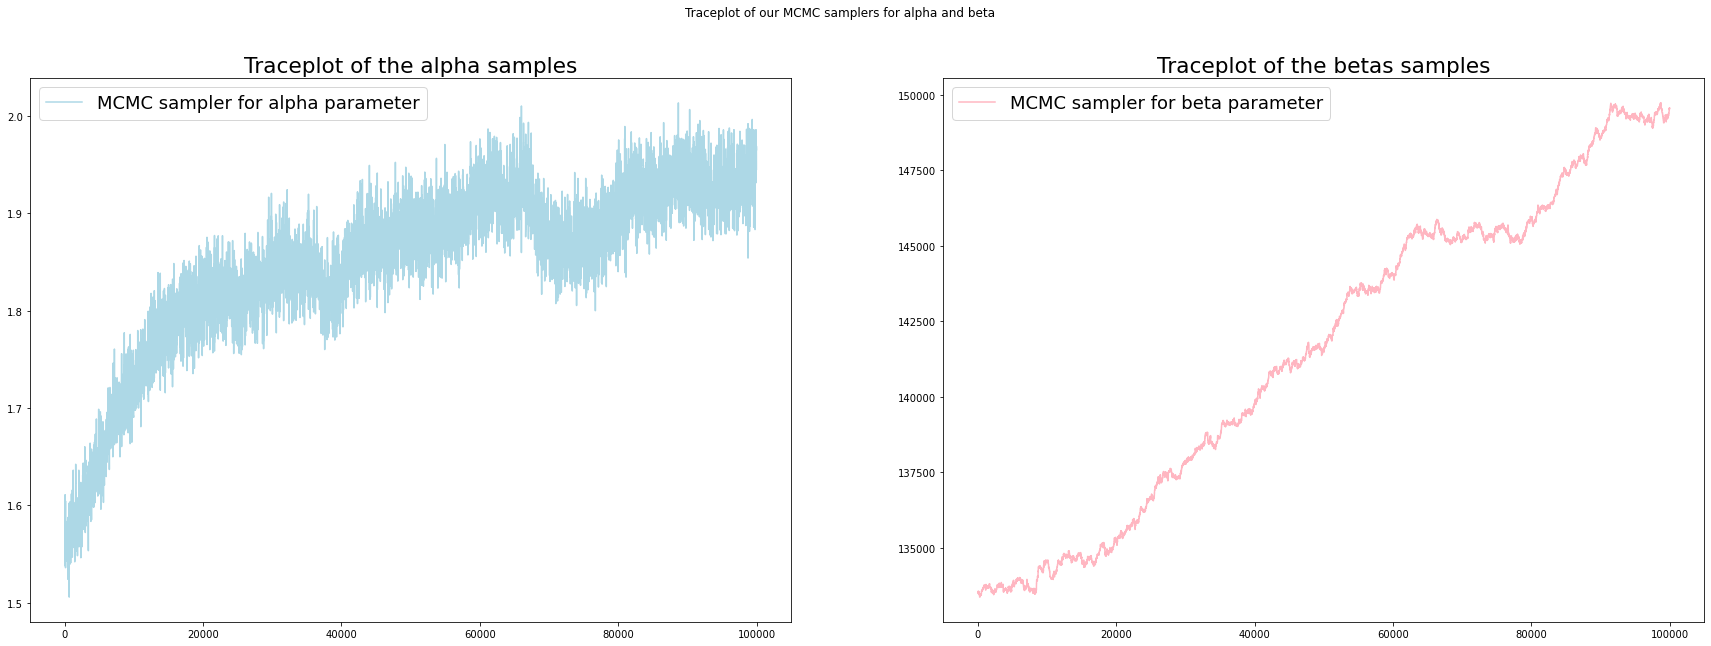

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (30, 10))
plt.suptitle('Traceplot of our MCMC samplers for alpha and beta')
plt.rcParams['font.size']=18
axes[0].set_title('Traceplot of the alpha samples')
axes[0].plot(range(len(alphas)), alphas, label = 'MCMC sampler for alpha parameter', color='lightblue')
axes[0].legend()
axes[1].set_title('Traceplot of the betas samples')
axes[1].plot(range(len(betas)), betas, label = 'MCMC sampler for beta parameter', color='lightpink')
axes[1].legend()
plt.show()

##### Traceplots of our samples with burning = 10%

In [22]:
burn_in = int(Gibbs_sweep/10)
alphas_burned, betas_burned = alphas[burn_in:], betas[burn_in:]

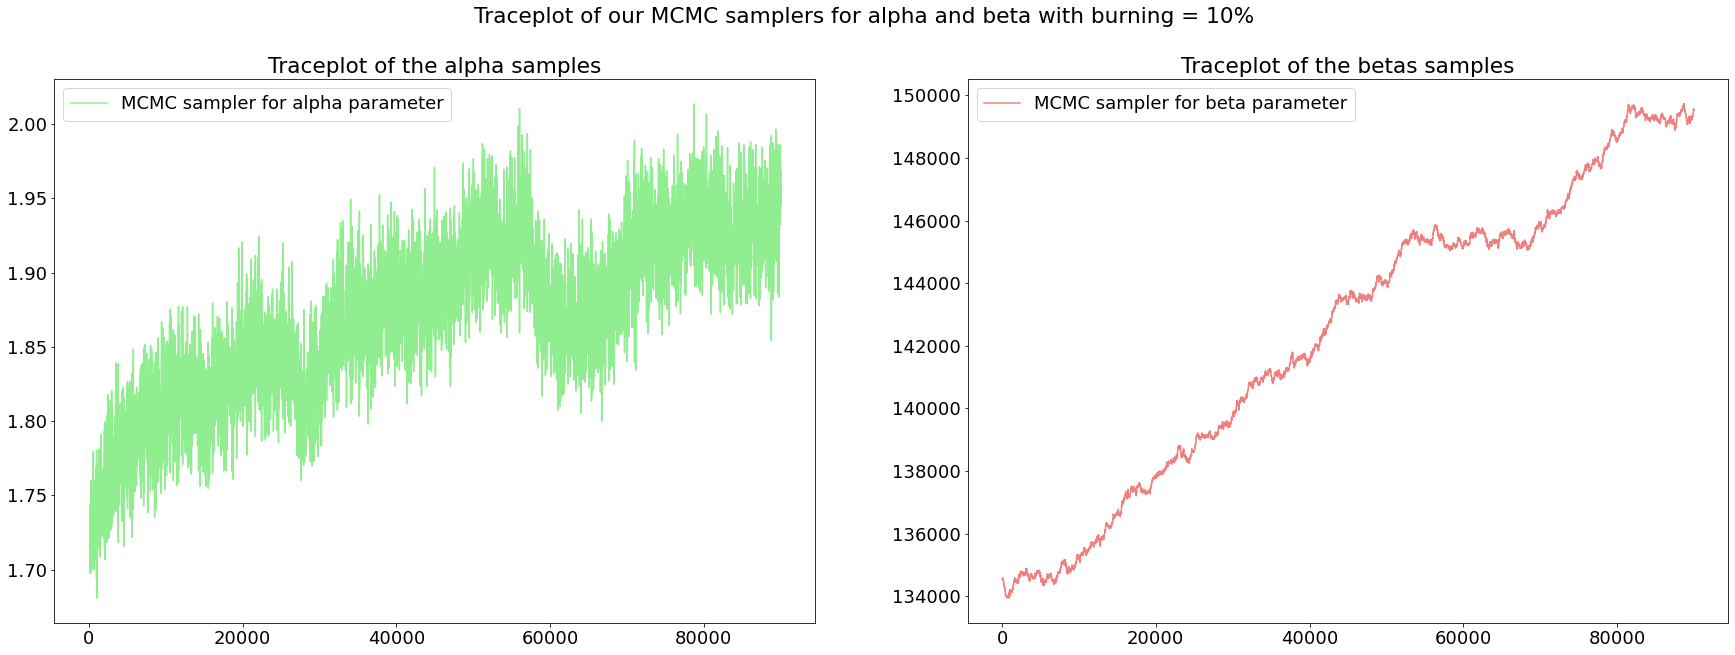

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (30, 10))
plt.suptitle('Traceplot of our MCMC samplers for alpha and beta with burning = 10%')
plt.rcParams['font.size']=18
axes[0].set_title('Traceplot of the alpha samples')
axes[0].plot(range(len(alphas_burned)), alphas_burned, label = 'MCMC sampler for alpha parameter', color='lightgreen')
axes[0].legend()
axes[1].set_title('Traceplot of the betas samples')
axes[1].plot(range(len(betas_burned)), betas_burned, label = 'MCMC sampler for beta parameter', color='lightcoral')
axes[1].legend()
plt.show()

##### Traceplots of our samples with thinning = 10 and burning = 10%

In [24]:
thinning_parameter = 10
alphas_thinned, betas_thinned = alphas_burned[::thinning_parameter], betas_burned[::thinning_parameter]

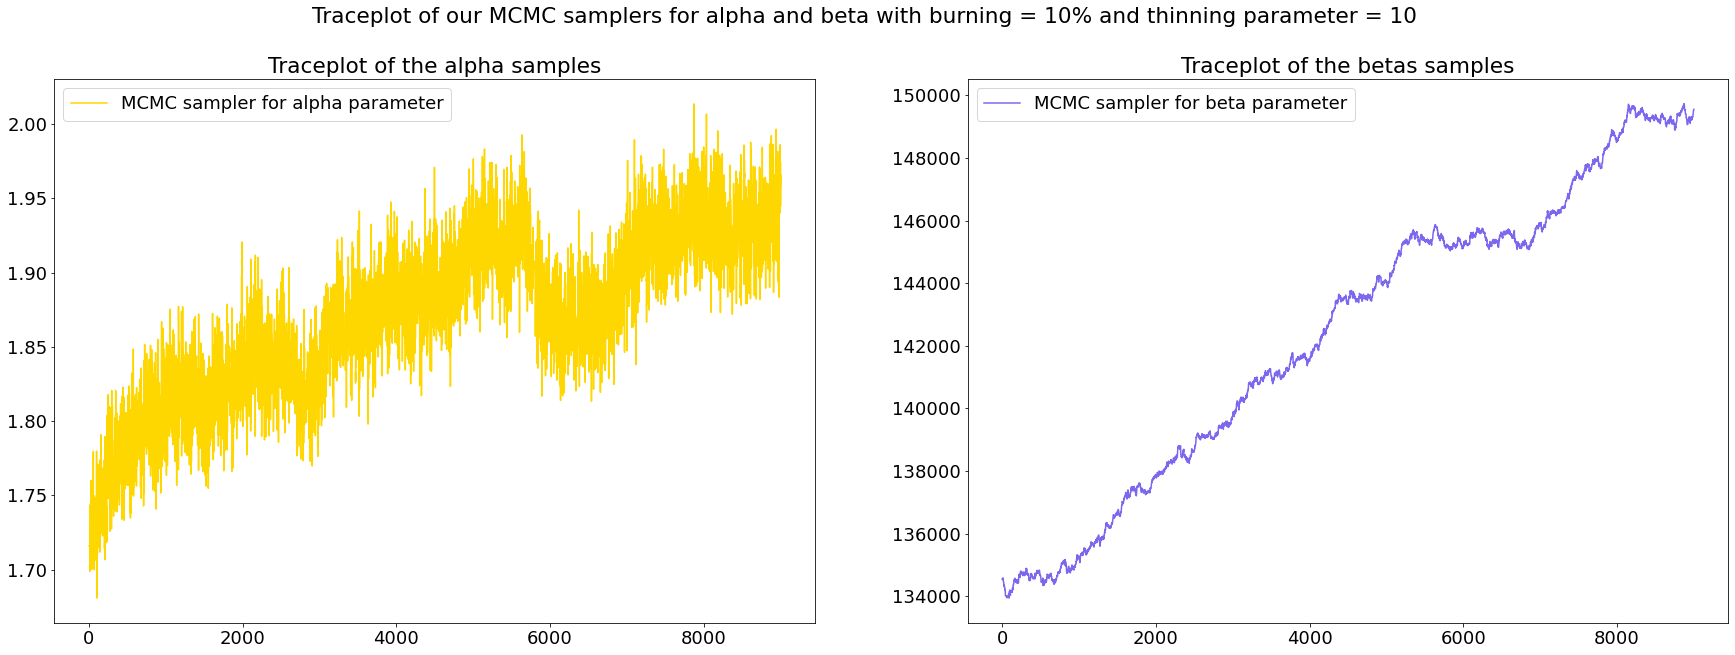

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (30, 10))
plt.suptitle('Traceplot of our MCMC samplers for alpha and beta with burning = 10% and thinning parameter = 10')
plt.rcParams['font.size']=18
axes[0].set_title('Traceplot of the alpha samples')
axes[0].plot(range(len(alphas_thinned)), alphas_thinned, label = 'MCMC sampler for alpha parameter', color='gold')
axes[0].legend()
axes[1].set_title('Traceplot of the betas samples')
axes[1].plot(range(len(betas_thinned)), betas_thinned, label = 'MCMC sampler for beta parameter', color='mediumslateblue')
axes[1].legend()
plt.show()

##### Check for convergence

As first sanity checks for convergence, several things may be pointed out:
- Even after thinning and burn-in, we can see a clear global trend of our MCMC sample, meaning that we may not have yet reached the stationnary distribution. Indeed, a trend in our traceplot indicates correlation between the different samples. 
- We may study the acceptance rate: a low acceptance rate may indicate that we may not yet have reached high density regions, which are the regions we want to attain. 

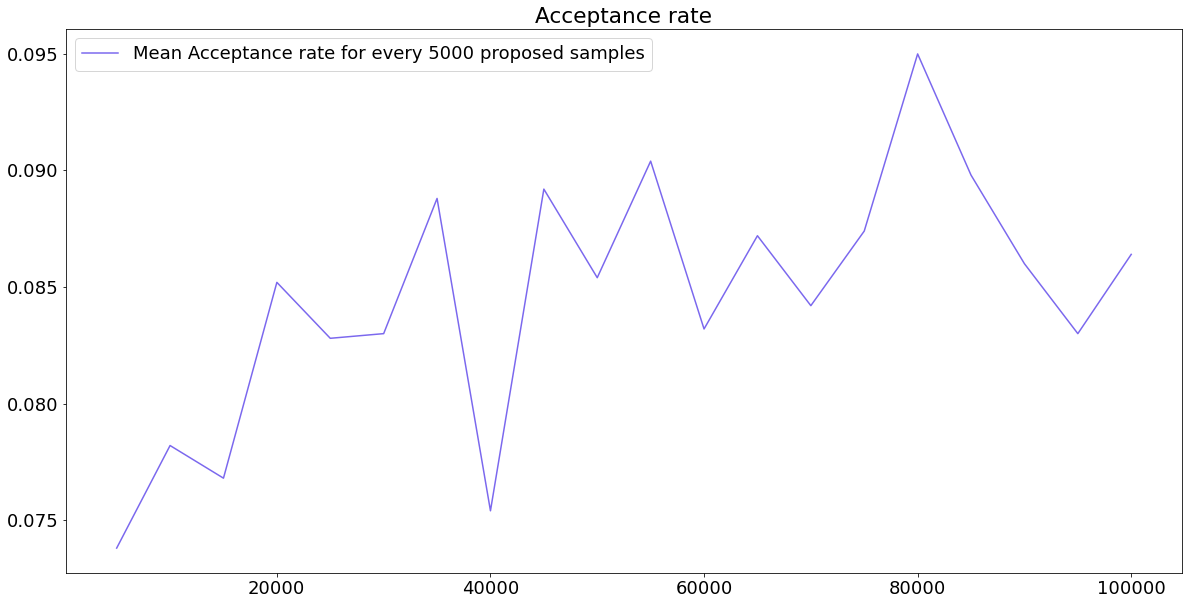

In [26]:
slices = np.linspace(0, 100000, 21)
counts = [np.mean(count[int(slices[i]):int(slices[i+1])]) for i in range(20)]
plt.figure(figsize=(20, 10))
plt.title('Acceptance rate')
plt.plot(slices[1:], counts, label='Mean Acceptance rate for every 5000 proposed samples', color='mediumslateblue')
plt.legend()
plt.show()

Therefore, from what we can see above, the acceptance rate increases over the iterations, but remains relatively low, meaning that we are slowly moving towards high acceptance regions, but have maybe not yet reached these regions. Therefore, we can strongly assume that the sampler for $\alpha$ and $\beta$ have not yet converged and are still searching for high density regions, explaining the clear trend in the traceplots.

Out of curiosity, let us check the traceplots for one theta_j, to see if the visual check might be misleading. I cannot replot it here (memory error) but checking the traceplot for one theta gives us the impression that our sampler has mixed:an illustration that the visual diagnostic might be misleading!

In order to try to tweak our sampler, there might be several steps to take:
- Get more sweeps ! 
- Change the initial values for our sampler: infer the values where our posterior might have high density values and start around these values
- Adjust the burn-in and the thinning parameter (auto-correlation plots)
- Change the proposal distributions ? 

##### Get more sweeps: 

In [27]:
a, b, c, d = 9, 6, 9, 0.00001
Gibbs_sweep = int(1e6)  #TODO: change it before re-running the entire notebook
Covariance_matrix = np.matrix([[0.1, 0], [0, 1000]])
alpha=1.54517349188
beta=133514.171939
theta = np.zeros(N)
for i in range(len(theta)):
    theta[i] = np.random.gamma(alpha, 1/beta)
alphas_2 = [alpha]
betas_2 = [beta]
thetas_2 = [theta]
count_2 = []
for _ in itertools.repeat(None, Gibbs_sweep):
    theta = Gibbs_step(alphas_2[-1], betas_2[-1], thetas_2[-1])
    thetas_2.append(theta)
    alpha_prop, beta_prop, c = MH_step(alphas_2[-1], betas_2[-1], thetas_2[-1])
    alphas_2.append(alpha_prop)
    betas_2.append(beta_prop)
    count_2.append(c)
print('We have finished 100000 iterations of the MH-in-Gibbs sample, and had an overall acceptance rate of ' + str(np.sum(count_2)/Gibbs_sweep))

We have finished 100000 iterations of the MH-in-Gibbs sample, and had an overall acceptance rate of 0.102414


###### Visualization of the Acceptance Rate

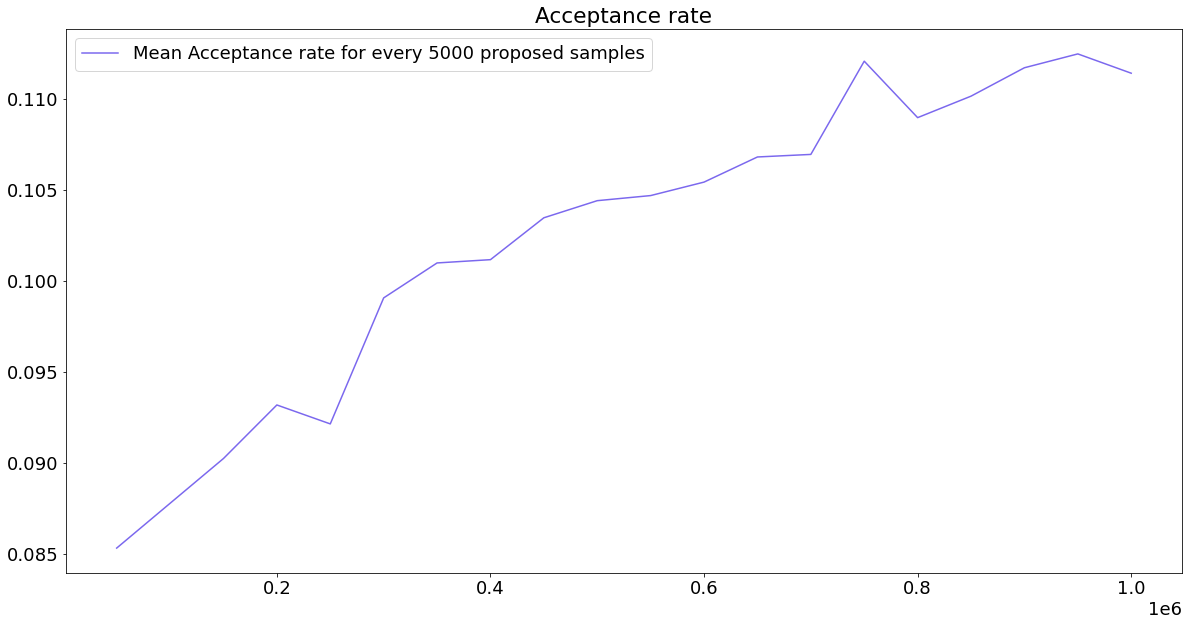

In [28]:
slices = np.linspace(0, 1000000, 21)
counts = [np.mean(count_2[int(slices[i]):int(slices[i+1])]) for i in range(20)]
plt.figure(figsize=(20, 10))
plt.title('Acceptance rate')
plt.plot(slices[1:], counts, label='Mean Acceptance rate for every 5000 proposed samples', color='mediumslateblue')
plt.legend()
plt.show()

We can see that the acceptance rate continues on getting bigger with the number of sweeps. This may signify that we have not yet reached the high density values.

##### TracePlots for Burn-in

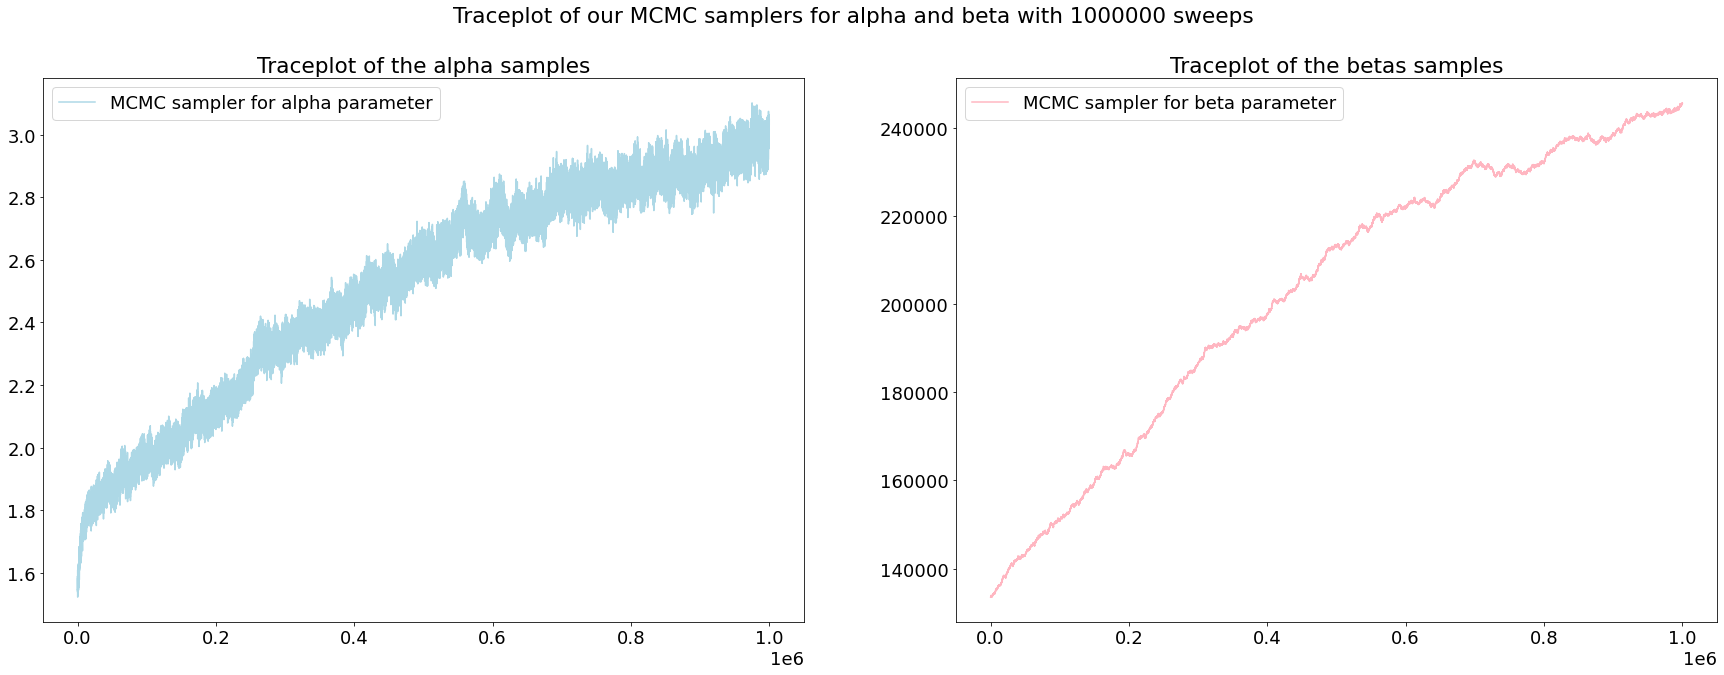

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (30, 10))
plt.suptitle('Traceplot of our MCMC samplers for alpha and beta with 1000000 sweeps')
plt.rcParams['font.size']=18
axes[0].set_title('Traceplot of the alpha samples')
axes[0].plot(range(len(alphas_2)), alphas_2, label = 'MCMC sampler for alpha parameter', color='lightblue')
axes[0].legend()
axes[1].set_title('Traceplot of the betas samples')
axes[1].plot(range(len(betas_2)), betas_2, label = 'MCMC sampler for beta parameter', color='lightpink')
axes[1].legend()
plt.show()

Here, we can clearly assess that our samples have not yet converged. We may not yet perform burn-in because the clear trend is visible for all of our simulations. 

##### Auto-Correlation plots for thinning

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(alphas_2, lags=10)
plt.show()

In [ ]:
plot_acf(betas_2, lags=10)
plt.show()

##### Adjusting the initial Parameters

We can restart the whole previous process, but this time we will use the initial values for $\alpha$, $\beta$ and $\theta$ that were ultimately computed by our previous MCMC samplers.

##### TracePlots after all these adjustments

##### Check for Convergences: large segments of the chain should have similar statistics: Gelman-Rubin coefficient

Out of computational efficiency, we may not be able right now to perform this sanity check. The core idea would be to run the sampler for different initial points and to get an idea of how the moments of the different chains are similar or not.

#### Proof of correctness for Metropolis-in-Gibbs sampler

We know that in order to check for the correctness of the MinG sampler, we need to show that we define an irreducible and aperiodic Markov Chain that has for stationnary (unique) distribution the target distribution.

##### Aperiodicity and Irreducibility

We know from the lecture that these two conditions may be solved by proving that from any current state, we can attain any state with a non-zero probability.  

This means that, from an initial vector $(\theta, \alpha, \beta)$, we will be able to attain $(\theta^{*}, \alpha^{*}, \beta^{*})$. We see that from the shape of the pdf simulating $\alpha$ and $\beta$ and the Gamma distribution taking care of $\theta$, we may be able to reach this objective vector (since the Gamma distribution is non zero over $\mathbb{R}^{+}$ and the likelihood is non zero either).

##### The target is the stationnary distribution: show that our Markov Chain simulated is reversible with respect to the transition Kernel

In order to show that our MC is reversible with respect to the tar